In [1]:
import anndata as ad
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
class BrainAtlasDataset(Dataset):
    def __init__(self, path_to_file: str):
        self.adata = ad.read_h5ad(path_to_file, backed="r")

    def __len__(self):
        return len(self.adata)

    def __getitem__(self, idx):
        c_x, c_y = self.adata.obs['center_x'][idx], self.adata.obs['center_y'][idx]

        return dict(
            idx=idx,
            position=torch.tensor([c_x.item(), c_y.item()])
        )


dataset = BrainAtlasDataset('atlas_brain_638850_CCF.h5ad')

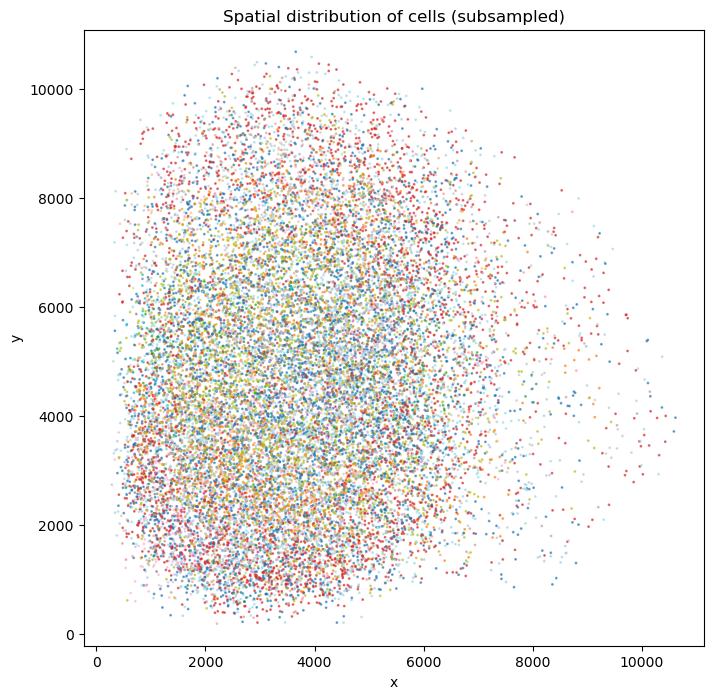

In [4]:
N = len(dataset)
n_plot = 20000

rng = np.random.default_rng(0)
idx = rng.choice(N, size=n_plot, replace=False)

obs = dataset.adata.obs.iloc[idx]

x = obs["center_x"].to_numpy()
y = obs["center_y"].to_numpy()
labels = obs["class_label"].to_numpy()

plt.figure(figsize=(8, 8))
plt.scatter(
    x,
    y,
    c=pd.Categorical(labels).codes,
    s=1,
    cmap="tab20",
    alpha=0.6
)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Spatial distribution of cells (subsampled)")
plt.axis("equal")
plt.show()

## Discussion on sampling procedures

What do you want to see with this this experiment?

- High vs Low inductive bias encoder (low would be FFN), what would be high?
- The effectiveness of different sampling procedures. For now use your best judgement, later discuss with the team. 


*Notes on Sampling Procedures*:

- One with diversity condition being violated, and one where it's not violated
- In violated diversity condition we should fix the class of the cell
- Separate the dataset into test vs train. Test dataset should be used in evaluations during training + linear probing


**Maintaining diversity condition in batches**

- Taking a batch ~ uniformly sampling the latents and running them through the generating process

*Method 1 of sampling (dis)similar pairs*:

Q1: If we are doing distance-based sampling, should we sample outside the batch without replacement in order to construct unique similar samples?
Q2: Here we are not sampling based on distance in the latent space, but we are sampling based on distance in the data space. Make sure it's not confusing to you or to the audience who will be reading it.

**Which configurations are we testing?**

- High/Low inductive bias
- Diversity Holds, Diversity Violated, Diversity violated + adjusted sampling regimes

*Diversity condition:* $p(A|z) = 0 \implies p(A) = 0$

**Sampling where diversity holds**

Given a sample $x \in \mathbb{R}^{550}$, sample similar sample as $\mathcal{N}(x, \sigma^{2})$ from the dataset, and remove the sampled datapoint from the candidates

Ok, I think random sampling might not be a good idea here. Let's do it in a bit different way.

- Take a large batch divisible by 2
- Divide the batch into 2 parts
- Take the nearest neighbor to the element in the first part of the batch in the second part of the batch - this is your positive pair, remove this pair and continue matching the same
- Pre-compute everything in some index json file, so we don't have to repeat this during training

In [4]:
batch_size = 20000  # adjust to your GPU / RAM

def collate_as_list(batch):
    return batch

loader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=False,
    pin_memory=True,
    num_workers=0,
    drop_last=True,
    collate_fn=collate_as_list
)

batch = next(iter(loader))

@torch.no_grad()
def match_pairs(batch_, batch_size: int):
    """
    Returns: list[tuple[int, int]]
      - pairs of (idx_from_partition1, idx_from_partition2)
      - idx values come from batch_item["idx"]
    Assumes:
      - batch_ is a list of dicts
      - each dict has 'position' (tensor [D]) and 'idx' (int)
      - batch_size is even, and len(batch_) == batch_size
    """
    assert len(batch_) == batch_size, (len(batch_), batch_size)
    assert batch_size % 2 == 0

    # Positions: [B, D]
    pos = torch.stack([b["position"] for b in batch_], dim=0)
    idxs = [int(b["idx"]) for b in batch_]

    half = batch_size // 2
    p1 = pos[:half]          # [H, D]
    p2 = pos[half:]          # [H, D]
    idxs1 = idxs[:half]
    idxs2 = idxs[half:]

    print("Computing distances")

    dists = torch.cdist(p1, p2, p=2)

    # Global greedy 1-1 assignment:
    # Sort all (i,j) by distance ascending, then take smallest that doesn't reuse i or j.
    H = half
    flat = dists.reshape(-1)                 # [H*H]
    order = torch.argsort(flat)              # [H*H]

    print("Sorted")

    used_i = [False] * H
    used_j = [False] * H
    pairs = []

    print("Matching")
    # k is an index of the flattened distance matrix - can be mapped back to distance between i in first and j in second partition
    for k in order.tolist():
        # Recover the row
        i = k // H

        # Recover the column
        j = k % H

        if not used_i[i] and not used_j[j]:
            used_i[i] = True
            used_j[j] = True
            pairs.append((idxs1[i], idxs2[j]))

            if len(pairs) == H:
                break

    return pairs

# match_pairs(batch, batch_size)

# for i, d in enumerate(dataset.adata):
#     if i % 10000 == 0:
#         print(i)
#     # print(d)

# print(batch)


/tmp/ipykernel_2307442/3385386990.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  c_x, c_y = self.adata.obs['center_x'][idx], self.adata.obs['center_y'][idx]


In [6]:
dataset.adata.layers

Layers with keys: log2p, raw